In [1]:
import openpiv.tools
import openpiv.process
import openpiv.scaling
import openpiv.preprocess
from skimage import io

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/alex/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


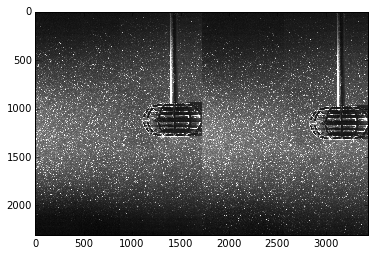

In [ ]:
file_a = 'Camera1-0101.tif'
file_b = 'Camera1-0102.tif'

im_a  = io.imread( file_a )
im_b  = io.imread( file_b )
imshow(np.c_[im_a,im_b],cmap='gray')

In [ ]:
# let's crop the region of interest
frame_a =  im_a[380:1980,0:1390]
frame_b =  im_b[380:1980,0:1390]
imshow(np.c_[frame_a,frame_b],cmap='gray')

In [ ]:
# Process the original cropped image and see the OpenPIV result:

# typical parameters:
window_size = 32 #pixels
overlap = 16 # pixels
search_area_size = 64 # pixels 
frame_rate = 40 # fps

# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = openpiv.process.extended_search_area_piv(
                                                       frame_a.astype(np.int32) , frame_b.astype(np.int32), 
                                                       window_size = window_size,
                                                       overlap = overlap, 
                                                       dt=1./frame_rate, 
                                                       search_area_size = search_area_size, 
                                                       sig2noise_method = 'peak2peak')
x, y = openpiv.process.get_coordinates( image_size = frame_a.shape, window_size = window_size, overlap = overlap )
u, v, mask = openpiv.validation.global_val( u, v, (-300.,300.),(-300.,300.))
u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.1 )
u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter = 3, kernel_size = 3)
x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
# save to a file
openpiv.tools.save(x, y, u, v, mask, 'test.txt', fmt='%9.6f', delimiter='\t')
openpiv.tools.display_vector_field('test.txt', scale=50, width=0.002)

In [ ]:
# masking using not optimal choice of the methods or parameters:
masked_a = openpiv.preprocess.dynamic_masking(frame_a,method='edges',filter_size=7,threshold=0.005)
masked_b = openpiv.preprocess.dynamic_masking(frame_b,method='intensity',filter_size=3,threshold=0.0)
imshow(np.c_[masked_a,masked_b],cmap='gray')

In [ ]:
# masking using optimal (manually tuned) set of parameters and the right method:
masked_a = openpiv.preprocess.dynamic_masking(frame_a,method='edges',filter_size=7,threshold=0.01)
masked_b = openpiv.preprocess.dynamic_masking(frame_b,method='edges',filter_size=7,threshold=0.01)
imshow(np.c_[masked_a,masked_b],cmap='gray')

In [ ]:
# Process the masked cropped image and see the OpenPIV result:

# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = openpiv.process.extended_search_area_piv(
                                                       masked_a.astype(np.int32) , masked_b.astype(np.int32), 
                                                       window_size = window_size,
                                                       overlap = overlap, 
                                                       dt=1./frame_rate, 
                                                       search_area_size = search_area_size, 
                                                       sig2noise_method = 'peak2peak')
x, y = openpiv.process.get_coordinates( image_size = masked_a.shape, window_size = window_size, overlap = overlap )
u, v, mask = openpiv.validation.global_val( u, v, (-300.,300.),(-300.,300.))
u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.1)
u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter = 3, kernel_size = 3)
x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
# save to a file
openpiv.tools.save(x, y, u, v, mask, 'test_masked.txt', fmt='%9.6f', delimiter='\t')
openpiv.tools.display_vector_field('test_masked.txt', scale=50, width=0.002)